In [ ]:
!pip install xgboost
!pip install pandas
!pip install openpyxl
!pip install scikit-learn
!pip install seaborn matplotlib

About Dataset

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
from google.colab import files
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime

In [ ]:
# Step 2: Upload the file manually if not done
uploaded = files.upload()

# Load the uploaded file into a pandas DataFrame
df = pd.read_excel(next(iter(uploaded)))



Saving Training_Dataset.xlsx to Training_Dataset.xlsx


In [ ]:
# Step 3: Inspect the dataset
print("Column Names in DataFrame:", df.columns.tolist())

Column Names in DataFrame: ['gender', 'Age', 'quantity', 'payment_method', 'w', 'Arrival_Time', 'Start_Time', 'Finish_Time', 'Wait_Time', 'Queue_Length', 'Counter_Number', 'Day']


In [ ]:
print(df.shape)

(1999, 12)


In [ ]:
print(df.head())

   gender  Age  quantity payment_method          w Arrival_Time Start_Time  \
0  Female   24        23           Cash 2021-01-01     11:34:00   11:49:00   
1  Female   33        12           Cash 2021-01-10     12:24:00   13:06:00   
2  Female   35        26           Cash 2021-01-04     18:00:00   18:04:00   
3    Male   46        30     Debit Card 2021-02-02     11:40:00   11:49:00   
4  Female   50        16           Cash 2021-02-02     16:35:00   16:38:00   

  Finish_Time       Wait_Time  Queue_Length  Counter_Number      Day  
0    11:54:00 0 days 00:15:00             3               2   Friday  
1    13:09:00 0 days 00:42:00             7               2   Sunday  
2    18:11:00 0 days 00:04:00             2               2   Monday  
3    11:56:00 0 days 00:09:00             3               1  Tuesday  
4    16:44:00 0 days 00:03:00             1               2  Tuesday  


In [ ]:
df.dtypes

,0
gender,object
Age,int64
quantity,int64
payment_method,object
w,datetime64[ns]
Arrival_Time,object
Start_Time,object
Finish_Time,object
Wait_Time,timedelta64[ns]
Queue_Length,int64


In [ ]:
df.isnull().sum()

,0
gender,0
Age,0
quantity,0
payment_method,0
w,0
Arrival_Time,0
Start_Time,0
Finish_Time,0
Wait_Time,0
Queue_Length,0


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   gender          1999 non-null   object         
 1   Age             1999 non-null   int64          
 2   quantity        1999 non-null   int64          
 3   payment_method  1999 non-null   object         
 4   w               1999 non-null   datetime64[ns] 
 5   Arrival_Time    1999 non-null   object         
 6   Start_Time      1999 non-null   object         
 7   Finish_Time     1999 non-null   object         
 8   Wait_Time       1999 non-null   timedelta64[ns]
 9   Queue_Length    1999 non-null   int64          
 10  Counter_Number  1999 non-null   int64          
 11  Day             1999 non-null   object         
dtypes: datetime64[ns](1), int64(4), object(6), timedelta64[ns](1)
memory usage: 187.5+ KB
None


In [ ]:
print(df.describe())

               Age     quantity                              w  \
count  1999.000000  1999.000000                           1999   
mean     38.914457    19.781891  2021-01-14 13:10:14.107053312   
min      13.000000    10.000000            2021-01-01 00:00:00   
25%      26.000000    15.000000            2021-01-05 00:00:00   
50%      39.000000    20.000000            2021-01-09 00:00:00   
75%      52.000000    25.000000            2021-02-01 00:00:00   
max      65.000000    30.000000            2021-02-05 00:00:00   
std      15.239469     6.055421                            NaN   

                       Wait_Time  Queue_Length  Counter_Number  
count                       1999   1999.000000     1999.000000  
mean   0 days 00:06:16.608304152      1.508754        1.945473  
min              0 days 00:00:00      0.000000        1.000000  
25%              0 days 00:00:00      0.000000        1.000000  
50%              0 days 00:02:00      1.000000        2.000000  
75%            

Preprocessing of Dataset

In [ ]:
# Step 4: Handle missing values
# Fill missing values for numeric columns with the mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill missing values for categorical columns with the most frequent value (mode)
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

In [ ]:
# Step 5: Convert time columns (handling datetime.time)
def time_to_seconds(time):
    if isinstance(time, datetime.time):
        return time.hour * 3600 + time.minute * 60 + time.second
    return None
# Apply the conversion to each relevant column
for col in ['Arrival_Time', 'Start_Time', 'Finish_Time']:
    df[col] = df[col].apply(time_to_seconds)

# Convert 'Wait_Time' to total seconds
df['Wait_Time'] = pd.to_timedelta(df['Wait_Time']).dt.total_seconds()

In [ ]:
# Step 6: Check for datetime64 columns and convert them
datetime_columns = df.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_columns:
    # Convert datetime to total seconds since epoch or any relevant format
    df[col] = (df[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [ ]:
# Step 7: Encode categorical data using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

In [ ]:
# Step 8: Separate features (X) and targets (y)
X = df.drop(columns=['Queue_Length', 'Counter_Number'])  # Using the actual names
y = df[['Queue_Length', 'Counter_Number']]                # Using the actual names

Splitting of the Data into test and training

In [ ]:
# Step 9: Check the data types of X to ensure compatibility with XGBoost
print("Feature Data Types:\n", X.dtypes)

# Step 10: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature Data Types:
 Age                             int64
quantity                        int64
w                               int64
Arrival_Time                    int64
Start_Time                      int64
Finish_Time                     int64
Wait_Time                     float64
gender_Male                      bool
payment_method_Credit Card       bool
payment_method_Debit Card        bool
Day_Monday                       bool
Day_Saturday                     bool
Day_Sunday                       bool
Day_Thursday                     bool
Day_Tuesday                      bool
Day_Wednesday                    bool
dtype: object


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1599, 16)
Shape of X_test: (400, 16)
Shape of y_train: (1599, 2)
Shape of y_test: (400, 2)


Model Training

In [ ]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Initialize XGBoost model and wrap it with MultiOutputRegressor for multiple targets
xg_reg_queue = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))

# Train the model
xg_reg_queue.fit(X_train, y_train)

# Make predictions on the test set
y_pred_queue = xg_reg_queue.predict(X_test)

  # Print Model Summary for each target
print("\nXGBoost Model Summary")
print("----------------------")
for i, estimator in enumerate(xg_reg_queue.estimators_):
    print(f"\nSummary for Target Variable {i + 1}:")
    print(f"  Number of Estimators: {estimator.n_estimators}")
    print(f"  Learning Rate: {estimator.learning_rate}")
    print(f"  Max Depth: {estimator.max_depth}")
    print(f"  Random State: {estimator.random_state}")



XGBoost Model Summary
----------------------

Summary for Target Variable 1:
  Number of Estimators: 100
  Learning Rate: 0.1
  Max Depth: 6
  Random State: 42

Summary for Target Variable 2:
  Number of Estimators: 100
  Learning Rate: 0.1
  Max Depth: 6
  Random State: 42


In [ ]:
# Calculate RMSE for Queue_Length and Counter_Number
rmse_queue_length = mean_squared_error(y_test['Queue_Length'], y_pred_queue[:, 0], squared=False)

# Print RMSE values to depict accuracy
print(f'XGBoost RMSE for Queue Length: {rmse_queue_length}')


XGBoost RMSE for Queue Length: 0.37611802116457305


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# # Print RMSE values to depict accuracy
# print(f'XGBoost RMSE for Queue Length: {rmse_queue_length}')

In [ ]:
rmse_counter_number = mean_squared_error(y_test['Counter_Number'], y_pred_queue[:, 1], squared=False)

print(f'XGBoost RMSE for Counter Number: {rmse_counter_number}')

XGBoost RMSE for Counter Number: 0.8666806273585688


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Find Accuracy of the Model

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

# Round predictions to the nearest integer for accuracy calculation
y_pred_rounded = np.round(y_pred_queue)

range_queue_length = 14
range_counter_number = 4
# Calculate "accuracy" by checking how many rounded predictions match the actual values
queue_accuracy = 1 - (rmse_queue_length / range_queue_length)
counter_accuracy = 1 - (rmse_counter_number / range_counter_number)

print(f'Accuracy for Queue Length: {queue_accuracy * 100:.2f}%')
print(f'Accuracy for Counter Number: {counter_accuracy * 100:.2f}%')

Accuracy for Queue Length: 97.31%
Accuracy for Counter Number: 78.33%


In [ ]:
import pandas as pd

# Get the first 10 rows of the test set
y_test_sample = y_test.head(10)
y_pred_queue_sample = y_pred_queue[:10]  # Get the first 10 predictions

# Create a DataFrame to display the actual and predicted values side-by-side
comparison_df = pd.DataFrame({
    "Actual Queue_Length": y_test_sample['Queue_Length'].values,
    "Predicted Queue_Length": y_pred_queue_sample[:, 0],
})

# Print the comparison DataFrame
print(comparison_df)


   Actual Queue_Length  Predicted Queue_Length
0                    2                1.015437
1                    0                0.000280
2                    0               -0.007758
3                    2                1.399753
4                    0               -0.002345
5                    2                2.163950
6                    3                2.526976
7                    0                0.005789
8                    0               -0.007827
9                    1                1.403829


In [ ]:


import pandas as pd

# Get the first 10 rows of the test set
y_test_sample = y_test.head(10)
y_pred_queue_sample = y_pred_queue[:10]  # Get the first 10 predictions

# Create a DataFrame to display the actual and predicted values side-by-side
comparison_df = pd.DataFrame({
    "Actual Counter_Number": y_test_sample['Counter_Number'].values,
    "Predicted Counter_Number": y_pred_queue_sample[:, 1]
})
# Print the comparison DataFrame
print(comparison_df)


   Actual Counter_Number  Predicted Counter_Number
0                      3                  2.365628
1                      3                  1.918646
2                      2                  2.190794
3                      1                  1.942006
4                      3                  2.396385
5                      2                  2.406183
6                      2                  1.700364
7                      2                  1.999327
8                      2                  1.861369
9                      1                  2.231371


In [ ]:
# Make predictions
y_pred_queue = xg_reg_queue.predict(X_test)


Actual vs Predicted Queue Length

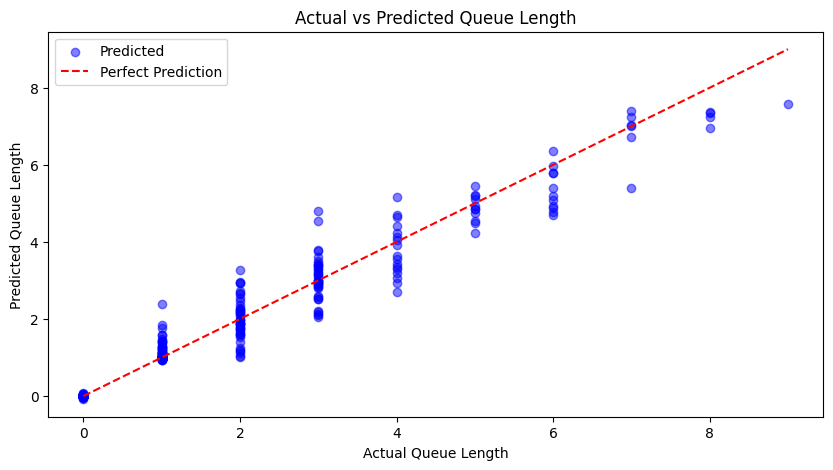

In [ ]:
import matplotlib.pyplot as plt

# Separate predicted values for Queue Length and Counter Number
y_pred_queue_length = y_pred_queue[:, 0]  # First column for Queue_Length predictions
y_pred_counter_number = y_pred_queue[:, 1]  # Second column for Counter_Number predictions

# Scatter plot of actual vs. predicted values for Queue Length
plt.figure(figsize=(10, 5))
plt.scatter(y_test['Queue_Length'], y_pred_queue_length, alpha=0.5, color='blue', label='Predicted')
plt.xlabel('Actual Queue Length')
plt.ylabel('Predicted Queue Length')
plt.title('Actual vs Predicted Queue Length')
plt.plot([y_test['Queue_Length'].min(), y_test['Queue_Length'].max()],
         [y_test['Queue_Length'].min(), y_test['Queue_Length'].max()],
         color='red', linestyle='--', label='Perfect Prediction')  # Diagonal line for perfect predictions
plt.legend()
plt.show()


Actual vs Predicted Counter Number

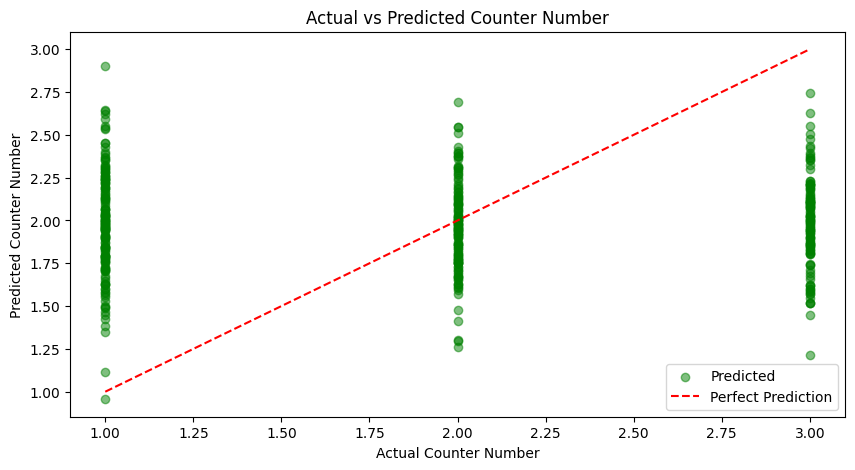

In [ ]:
# # Scatter plot of actual vs. predicted values for Counter Number
# plt.figure(figsize=(10, 5))
# plt.scatter(y_test['Counter_Number'], y_pred_counter_number, alpha=0.5, color='green', label='Predicted')
# plt.xlabel('Actual Counter Number')
# plt.ylabel('Predicted Counter Number')
# plt.title('Actual vs Predicted Counter Number')
# plt.plot([y_test['Counter_Number'].min(), y_test['Counter_Number'].max()],
#          [y_test['Counter_Number'].min(), y_test['Counter_Number'].max()],
#          color='red', linestyle='--', label='Perfect Prediction')  # Diagonal line for perfect predictions
# plt.legend()
# plt.show()

Feature Importance for Queue Length Prediction

<Figure size 1000x600 with 0 Axes>

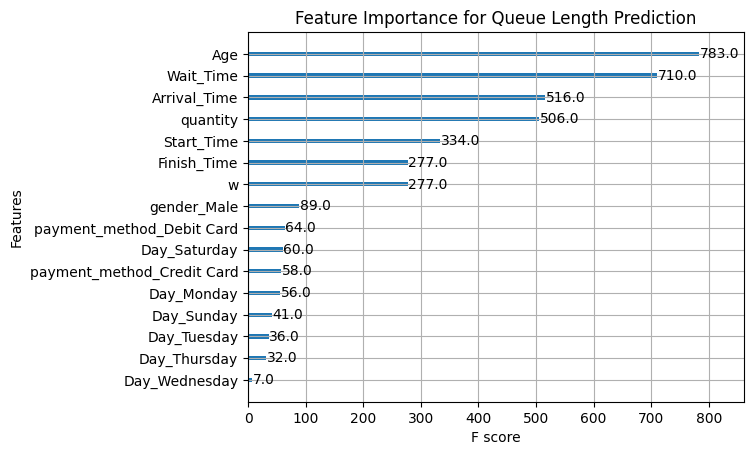

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance for Queue_Length (first target in MultiOutputRegressor)
plt.figure(figsize=(10, 6))
plot_importance(xg_reg_queue.estimators_[0], importance_type="weight")
plt.title('Feature Importance for Queue Length Prediction')
plt.show()


Feature Importance for Counter Number Prediction

<Figure size 1000x600 with 0 Axes>

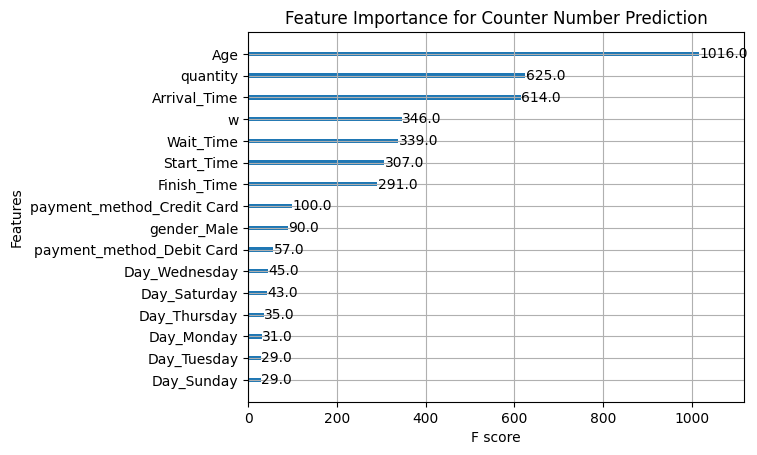

In [ ]:
# Plot feature importance for Counter_Number (second target in MultiOutputRegressor)
plt.figure(figsize=(10, 6))
plot_importance(xg_reg_queue.estimators_[1], importance_type="weight")
plt.title('Feature Importance for Counter Number Prediction')
plt.show()

Correlation Matrix

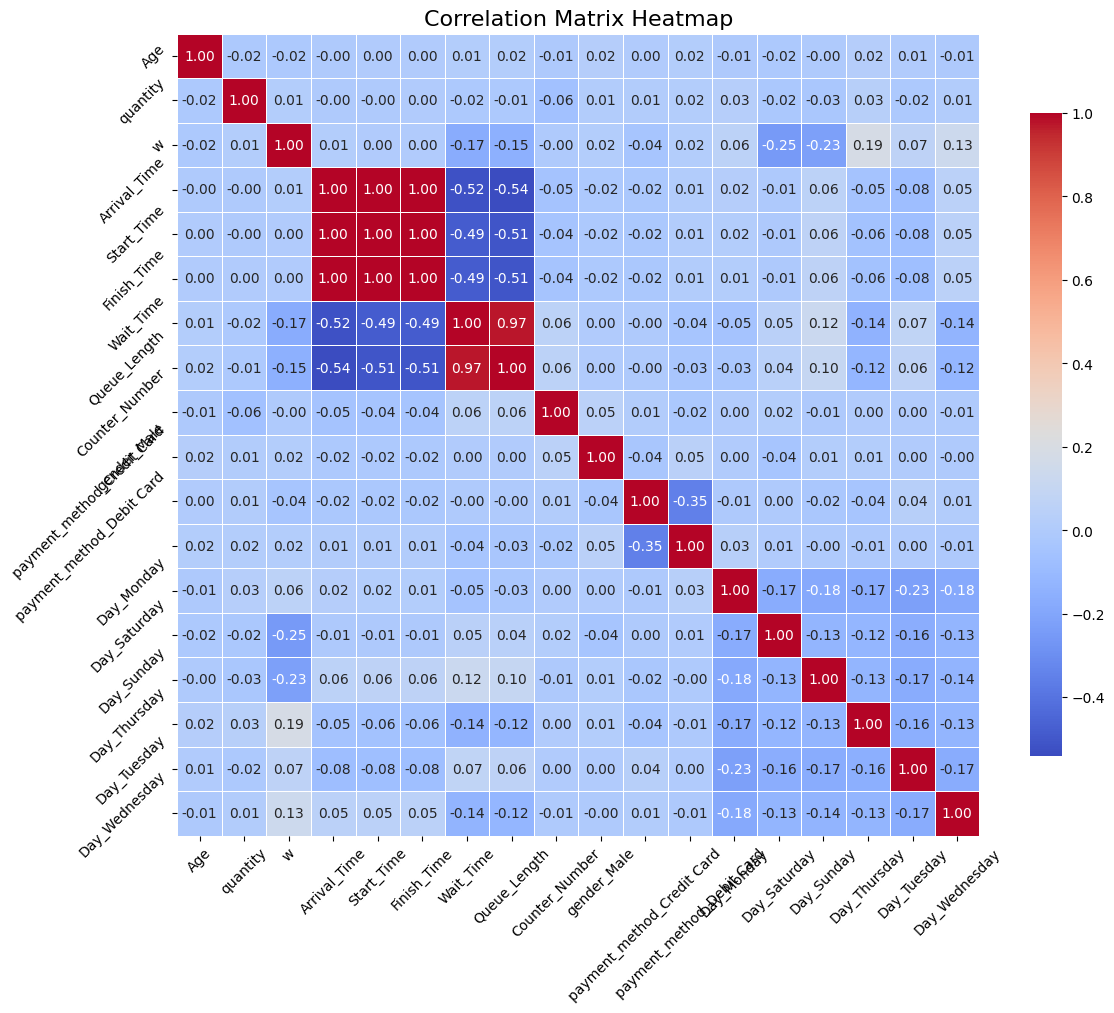

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'df' is already your DataFrame with relevant data loaded.

# Step 4: Calculate the correlation matrix
correlation_matrix = df.corr()

# Step 5: Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Step 6: Create the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

# Step 7: Set titles and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()

# Step 8: Show the heatmap
plt.show()


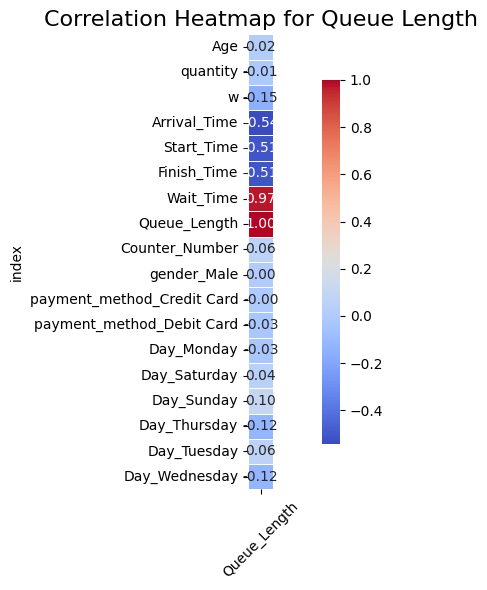

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Load your dataset (assuming you have already done this)
# df = pd.read_excel('Training_Dataset.xlsx')  # Uncomment if you're loading from a file

# Step 3: Prepare your data (ensure you've done preprocessing if needed)
# Assuming 'Queue_Length' and 'Counter_Number' are present in the DataFrame

# Step 4: Calculate the correlation matrix for Queue_Length
queue_length_corr = df.corr()['Queue_Length'].reset_index()

# Step 5: Set up the matplotlib figure for Queue Length
plt.figure(figsize=(10, 6))

# Step 6: Create the heatmap for Queue_Length
sns.heatmap(queue_length_corr.set_index('index'), annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

# Step 7: Set titles and labels for Queue Length Heatmap
plt.title('Correlation Heatmap for Queue Length', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



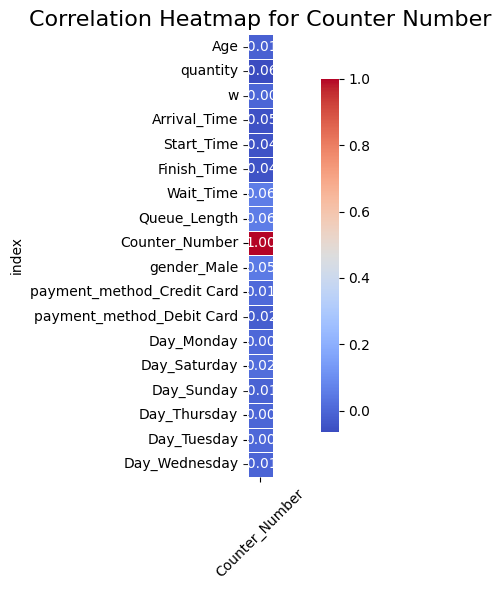

In [ ]:
# Step 8: Calculate the correlation matrix for Counter_Number
counter_number_corr = df.corr()['Counter_Number'].reset_index()

# Step 9: Set up the matplotlib figure for Counter Number
plt.figure(figsize=(10, 6))

# Step 10: Create the heatmap for Counter_Number
sns.heatmap(counter_number_corr.set_index('index'), annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

# Step 11: Set titles and labels for Counter Number Heatmap
plt.title('Correlation Heatmap for Counter Number', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Save trained model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib

# Save the MultiOutputRegressor XGBoost model
joblib_file_path = "/content/drive/MyDrive/Colab_Notebooks/xg_reg_queue_model.joblib"  # Adjust the path if necessary
joblib.dump(xg_reg_queue, joblib_file_path)

print(f"Model saved to {joblib_file_path}")


Model saved to /content/drive/MyDrive/Colab_Notebooks/xg_reg_queue_model.joblib


In [ ]:
# Load the model
xg_reg_queue_loaded = joblib.load(joblib_file_path)
print("Model loaded successfully.")


Model loaded successfully.
